In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Paths to the prepped data files
base_path = './data/prepped_data/'  # Adjusted base path to where your files are now
X_train_path = base_path + 'X_train.csv'
X_test_path = base_path + 'X_test.csv'
y_train_path = base_path + 'y_train.csv'
y_test_path = base_path + 'y_test.csv'

# Loading the datasets
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Assuming the last columns of X_train and X_test are year, month, day, hour for reconstructing the datetime index
X_train['datetime'] = pd.to_datetime(X_train[['year', 'month', 'day', 'hour']])
X_test['datetime'] = pd.to_datetime(X_test[['year', 'month', 'day', 'hour']])
y_train.index = pd.to_datetime(X_train['datetime'])
y_test.index = pd.to_datetime(X_test['datetime'])

# Exclude non-numerical columns before scaling
columns_to_scale = X_train.columns.difference(['year', 'month', 'day', 'hour', 'datetime'])

# Initialize the scaler for the features
scaler_X = MinMaxScaler()

# Scale 'X' features (excluding non-numerical columns)
X_train_scaled = scaler_X.fit_transform(X_train[columns_to_scale])
X_test_scaled = scaler_X.transform(X_test[columns_to_scale])

# Initialize a separate scaler for the target variable
scaler_y = MinMaxScaler()

# Scale 'y' (the target variable)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


In [2]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train_scaled shape:", y_train_scaled.shape)
print("y_test_scaled shape:", y_test_scaled.shape)


X_train_scaled shape: (56770, 36)
X_test_scaled shape: (14193, 36)
y_train_scaled shape: (56770,)
y_test_scaled shape: (14193,)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Defining the model
model = Sequential([
    SimpleRNN(50, input_shape=(1, X_train_scaled.shape[1])),  # 50 RNN units
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Summary of the model architecture
model.summary()

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=3, validation_split=0.2)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test_reshaped, y_test_scaled)

(test_loss, history.history)


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         4,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,401 (17.19 KB)

 Trainable params: 4,401 (17.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 354us/step - loss: 0.0032 - val_loss: 0.0026
Epoch 2/3
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 4.8950e-05 - val_loss: 0.0010
Epoch 3/3
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 3.5429e-05 - val_loss: 7.5852e-04
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step - loss: 0.0012


(0.0015043494058772922,
 {'loss': [0.0008054964710026979, 4.557462307275273e-05, 3.80280616809614e-05],
  'val_loss': [0.0025728479959070683,
   0.0010359258158132434,
   0.0007585155544802547]})

# LSTM Implementation

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming X_train_reshaped and y_train_scaled are prepared as before
model = Sequential([
    # Input layer is inferred from the input_shape argument in the first layer
    LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=5, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_reshaped, y_test_scaled)

print(f"Test Loss: {test_loss}")


Epoch 1/5
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 719us/step - loss: 0.0023 - val_loss: 2.3710e-04
Epoch 2/5
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - loss: 2.4116e-04 - val_loss: 2.5540e-04
Epoch 3/5
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step - loss: 1.8061e-04 - val_loss: 5.6868e-04
Epoch 4/5
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - loss: 1.5489e-04 - val_loss: 8.1319e-04
Epoch 5/5
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - loss: 1.3717e-04 - val_loss: 5.8331e-04
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 0.0048
Test Loss: 0.004676255863159895


# GRU Implementation

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Input layer is inferred from the input_shape in the first layer
    GRU(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=5, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_reshaped, y_test_scaled)

print(f"Test Loss: {test_loss}")


Epoch 1/5
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 746us/step - loss: 0.0021 - val_loss: 0.0011
Epoch 2/5
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - loss: 2.7921e-04 - val_loss: 2.9545e-04
Epoch 3/5
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - loss: 2.0406e-04 - val_loss: 0.0012
Epoch 4/5
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - loss: 1.6285e-04 - val_loss: 0.0037
Epoch 5/5
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - loss: 1.4435e-04 - val_loss: 0.0036
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - loss: 7.6027e-04
Test Loss: 0.002988133579492569


**Recommendation:**  
Given the observed performances, the LSTM model appears to be more suitable for our dataset and task. It generalizes better to unseen data, as evidenced by the lower test loss. Pursuing the LSTM model in more detail could involve:

- **Hyperparameter Tuning:** Experiment with different numbers of units in the LSTM layers, learning rates, and batch sizes.
- **Model Complexity:** Try adding more LSTM layers or adjusting the dropout rates to see if the model's generalization capability can be improved further.
- **Regularization Techniques:** Beyond dropout, consider trying other regularization techniques like L1/L2 regularization on the LSTM layers to control overfitting.
- **Early Stopping:** Implement early stopping during training to stop the training process when the validation loss stops decreasing, helping prevent overfitting.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Data reshaping for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Model definition
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Model summary
model.summary()

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=10, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_reshaped, y_test_scaled)

print(f"Test Loss: {test_loss}")


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 50)          │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,201 (157.04 KB)

 Trainable params: 40,201 (157.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 727us/step - loss: 0.0021 - val_loss: 1.8879e-04
Epoch 2/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step - loss: 2.4866e-04 - val_loss: 0.0027
Epoch 3/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step - loss: 1.8300e-04 - val_loss: 6.0956e-04
Epoch 4/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step - loss: 1.4674e-04 - val_loss: 7.2439e-04
Epoch 5/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - loss: 1.2076e-04 - val_loss: 5.8521e-04
Epoch 6/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - loss: 1.2090e-04 - val_loss: 0.0034
Epoch 7/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step - loss: 1.0533e-04 - val_loss: 0.0032
Epoch 8/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - loss: 8.8022e-05 - val_loss: 0.0076
Epoch 9/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - loss: 8.3761e-05 - val_loss: 0.0030
Epoch 10/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - loss: 6.8302e-05 - val_loss: 0.0046
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - lo

## Adding TimeseriesGenerator

Epoch 1/10


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  3/885 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - loss: 0.0405 

/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


885/885 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - loss: 0.0075 - val_loss: 0.0059
Epoch 2/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 48s 55ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 3/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - loss: 7.7019e-04 - val_loss: 0.0012
Epoch 4/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - loss: 5.7414e-04 - val_loss: 0.0055
Epoch 5/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - loss: 5.5513e-04 - val_loss: 0.0036
Epoch 6/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - loss: 3.9966e-04 - val_loss: 0.0033
Epoch 7/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - loss: 7.6957e-04 - val_loss: 0.0014
Epoch 8/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 48s 55ms/step - loss: 3.8406e-04 - val_loss: 0.0037
Epoch 9/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - loss: 1.2982e-04 - val_loss: 0.0057
Epoch 10/10
885/885 ━━━━━━━━━━━━━━━━━━━━ 48s 55ms/step - loss: 1.2569e-04 - val_loss: 0.0015
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Mean Squared Error: 8194120.060932401
Mean Absolute Erro

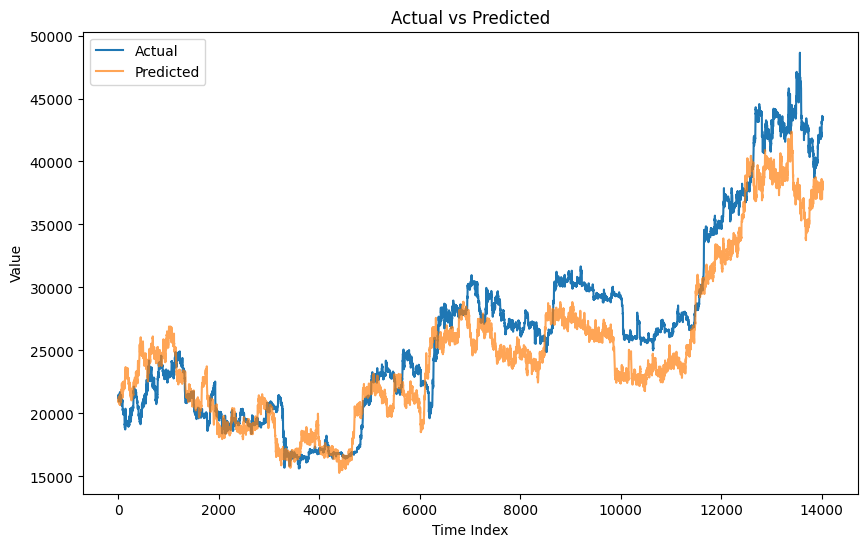

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

n_input = 168  # The number of time steps to look back for predictions
n_features = X_train_scaled.shape[1]  # The number of features in the dataset

# Create the TimeseriesGenerator for training and validation sets
train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=n_input, batch_size=64)
validation_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=n_input, batch_size=64)

# Define the LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(n_input, n_features)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Make predictions
y_pred_scaled = model.predict(validation_generator)

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Evaluate the model
y_test_original = y_test.values.flatten()[:len(y_pred)]  # Adjust length if necessary
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared Score: {r2}')

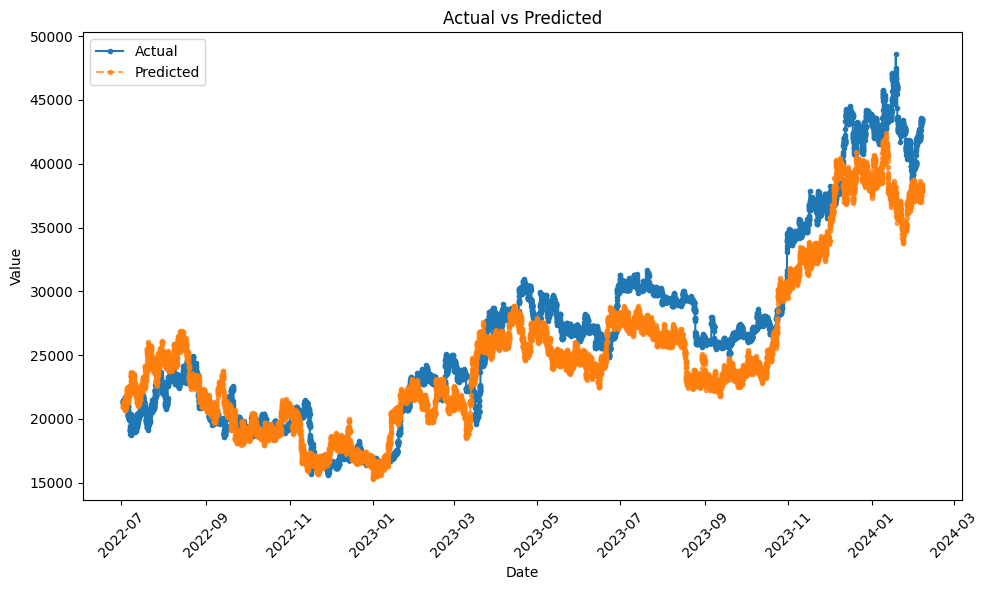

In [28]:
test_dates_aligned = X_test['datetime'].values[-len(y_pred):]

# Visualization with actual datetime on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(test_dates_aligned, y_test_original, label='Actual', marker='.', linestyle='-')
plt.plot(test_dates_aligned, y_pred, label='Predicted', alpha=0.7, marker='.', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels
plt.show()
